In [1]:
import pandas as pd 
import numpy as np

In [2]:
df = pd.read_csv("/Users/florian/Documents/github/DP2/Energy_production_price_prediction/HEFTcom24/data/features.csv")

## Prep for ARIMA

In [3]:
df = df.dropna()

In [4]:
def adf_test(series):
    """
    Perform the Augmented Dickey-Fuller test for stationarity.
    """
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for k, v in result[4].items():
        print("Critical Values")
        print(f"    {k}, {v}")
    return result[1] < 0.05

In [5]:
df["valid_time"] = pd.to_datetime(df["valid_time"])

In [6]:
solar = df.set_index("valid_time")[["Solar_MWh_credit"]]

In [7]:
solar

,Solar_MWh_credit
valid_time,
2020-09-21 00:00:00+00:00,0.0
2020-09-21 00:30:00+00:00,0.0
2020-09-21 01:00:00+00:00,0.0
2020-09-21 01:30:00+00:00,0.0
2020-09-21 02:00:00+00:00,0.0
...,...
2024-05-19 21:30:00+00:00,0.0
2024-05-19 22:00:00+00:00,0.0
2024-05-19 22:30:00+00:00,0.0


In [8]:
# Drop na 
solar = solar.dropna()

In [9]:
adf_test(solar)

ADF Statistic: -13.000857124162122
p-value: 2.689244214260966e-24
Critical Values
    1%, -3.4304529641854744
Critical Values
    5%, -2.8615855082687554
Critical Values
    10%, -2.5667942225092055


np.True_

In [10]:
# Differenzierung

solar_diff = solar.diff().dropna()

In [11]:
adf_test(solar_diff)

ADF Statistic: -59.23325997022704
p-value: 0.0
Critical Values
    1%, -3.430452956080028
Critical Values
    5%, -2.86158550468636
Critical Values
    10%, -2.566794220602407


True

In [12]:
# Saisonalität 

solar_seasonal_diff = solar.diff(48).dropna()

In [13]:
adf_test(solar_seasonal_diff)

ADF Statistic: -40.96015604016055
p-value: 0.0
Critical Values
    1%, -3.430453029075018
Critical Values
    5%, -2.8615855369482377
Critical Values
    10%, -2.5667942377744084


True

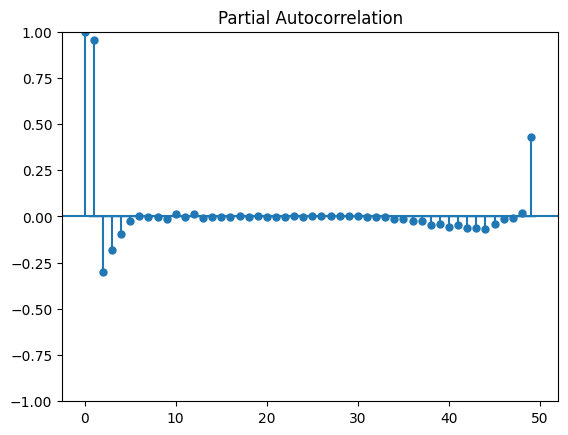

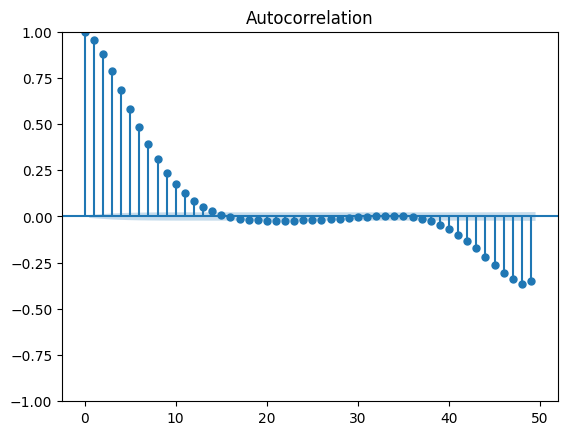

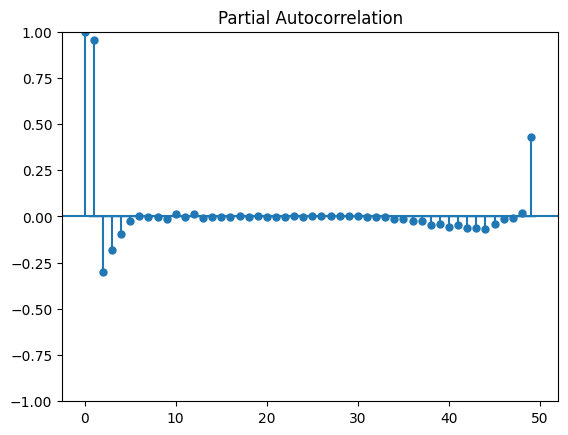

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(solar.diff(48).dropna())
plot_pacf(solar.diff(48).dropna())

## ARIMA+GARCH model

In [15]:
solar.index = pd.date_range(start= solar.index[0], periods= len(solar), freq= "30min")

In [16]:
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model


model = ARIMA(solar, order=(1,1,1))
model_fit = model.fit()
residuals = model_fit.resid
garch_model = arch_model(residuals, vol= "GARCH", p=1, q=1)  
garch_fit = garch_model.fit()
print(model_fit.summary())
print(garch_fit.summary())  

Iteration:      1,   Func. Count:      6,   Neg. LLF: 401351.5120544298
Iteration:      2,   Func. Count:     14,   Neg. LLF: 837685.6264525428
Iteration:      3,   Func. Count:     20,   Neg. LLF: 289740.7532334934
Iteration:      4,   Func. Count:     27,   Neg. LLF: 267401.35296609905
Iteration:      5,   Func. Count:     33,   Neg. LLF: 271810.780665543
Iteration:      6,   Func. Count:     39,   Neg. LLF: 262482.45681968034
Iteration:      7,   Func. Count:     44,   Neg. LLF: 262502.0944916628
Iteration:      8,   Func. Count:     49,   Neg. LLF: 381852.9087224761
Iteration:      9,   Func. Count:     57,   Neg. LLF: 363426.584358193
Iteration:     10,   Func. Count:     65,   Neg. LLF: 331501.7463178259
Iteration:     11,   Func. Count:     74,   Neg. LLF: 307064.8537313991
Iteration:     12,   Func. Count:     83,   Neg. LLF: 262582.90617465513
Iteration:     13,   Func. Count:     91,   Neg. LLF: 262492.3687484749
Iteration:     14,   Func. Count:    106,   Neg. LLF: 1111860.7

In [25]:
import optuna
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error

# Parameter-Grid
param_grid = {
    'p': (0, 3),
    'd': (0, 48),
    'q': (0, 3),
    'p_garch': (1, 3),
    'q_garch': (1, 3)
}

def objective(trial):
    p = trial.suggest_int('p', param_grid['p'][0], param_grid['p'][1])
    d = trial.suggest_int('d', param_grid['d'][0], param_grid['d'][1])
    q = trial.suggest_int('q', param_grid['q'][0], param_grid['q'][1])

    try:
        model = ARIMA(solar, order=(p, d, q))
        arima_fit = model.fit(disp=False)
        residuals = arima_fit.resid

        # GARCH Hyperparameter
        p_garch = trial.suggest_int('p_garch', param_grid['p_garch'][0], param_grid['p_garch'][1])
        q_garch = trial.suggest_int('q_garch', param_grid['q_garch'][0], param_grid['q_garch'][1])

        garch_model = arch_model(residuals, vol='Garch', p=p_garch, q=q_garch)
        garch_fit = garch_model.fit(disp='off')

        # Bewertung des Modells
        aic = arima_fit.aic #+ garch_fit.aic
        return aic
    except:
        return float('inf')

In [26]:
# Optuna-Studie erstellen und optimieren
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Beste Hyperparameter
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-10-07 20:37:03,764] A new study created in memory with name: no-name-728a1809-cc2d-4d6b-8d5b-1ab61b5dd0ce
[I 2024-10-07 20:37:03,767] Trial 0 finished with value: inf and parameters: {'p': 1, 'd': 44, 'q': 2}. Best is trial 0 with value: inf.
[I 2024-10-07 20:37:03,769] Trial 1 finished with value: inf and parameters: {'p': 0, 'd': 0, 'q': 2}. Best is trial 0 with value: inf.
[I 2024-10-07 20:37:03,771] Trial 2 finished with value: inf and parameters: {'p': 1, 'd': 27, 'q': 1}. Best is trial 0 with value: inf.
[I 2024-10-07 20:37:03,773] Trial 3 finished with value: inf and parameters: {'p': 3, 'd': 10, 'q': 1}. Best is trial 0 with value: inf.
[I 2024-10-07 20:37:03,774] Trial 4 finished with value: inf and parameters: {'p': 2, 'd': 29, 'q': 1}. Best is trial 0 with value: inf.
[I 2024-10-07 20:37:03,775] Trial 5 finished with value: inf and parameters: {'p': 2, 'd': 31, 'q': 0}. Best is trial 0 with value: inf.
[I 2024-10-07 20:37:03,777] Trial 6 finished with value: inf and 

Best trial:
  Value: inf
  Params: 
    p: 1
    d: 44
    q: 2
